In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/huge-stock-market-crash-2022/stock_market_crash_2022.csv


In [40]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize
import nltk
import gensim
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import re

In [41]:
df=pd.read_csv('/kaggle/input/huge-stock-market-crash-2022/stock_market_crash_2022.csv')

In [42]:
df = df.dropna(subset=['hashtags']).drop_duplicates()

In [43]:
df = df[df['language'] == 'en']

In [44]:
df.head()

,id,text,text_sentiment,username,hashtags,created_at,user followers count,replycount,retweetcount,likecount,quotecount,language,media,retweetedTweet,quotedtweet,inReplyToTweetId,inReplyToUser,mentionedUsers
0,1538666561615015938,When will the #NYSE #stockmarketcrash happen?,Neutral,tradexlnc,"['NYSE', 'stockmarketcrash']",2022-06-19 23:34:29+00:00,10669,0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,NaN
1,1538665013799489536,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,niftymonday,"['stockmarkets', 'stockmarketcrash', 'trading'...",2022-06-19 23:28:20+00:00,100,0,1,8,0,en,NaN,NaN,NaN,NaN,NaN,NaN
2,1538660868027830274,The stock market needs to crash hard to make i...,Negative,kyle132313,"['stockmarketcrash', 'economy', 'rich', 'Fed']",2022-06-19 23:11:52+00:00,0,0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,NaN
3,1538657239849836544,"Those who are ""Buying on DIP"" will very soon b...",Neutral,ChintanRajput16,"['stockmarketcrash', 'StocksToBuy', 'stockstow...",2022-06-19 22:57:27+00:00,54,0,2,2,0,en,NaN,NaN,NaN,NaN,NaN,NaN
4,1538654339044196358,@rdrhwke I wish our so-called President were t...,Positive,DrPCJustice,"['Bidenomics', 'inflation', 'recession', 'stoc...",2022-06-19 22:45:55+00:00,28,0,0,0,0,en,NaN,NaN,NaN,1.538653e+18,https://twitter.com/rdrhwke,"[User(username='rdrhwke', id=43753976, display..."


In [45]:
# Clean text function
def clean_text(text):
    text = BeautifulSoup(text,'html.parser').get_text()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#(\w+)', r'\1', text)   # Remove hashtags (or keep hashtags but remove '#' symbol)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if len(word) > 2]  # Remove tokens with less than 3 letters
    tokens = [word.lower() for word in tokens]  # Lowercase all tokens
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)


In [46]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer = WordNetLemmatizer()
def process_text(text):

    # Tokenize and clean the document
    tokens = clean_text(text)
    # Lemmatize the tokens if they are in the reduced vocabulary
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word in reduced_vocab]
    # Combine tokens back into a string
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# preparation for sentimental analysis
SA_data = df[['text','text_sentiment']]
SA_data['text_preprocessed'] = SA_data['text'].apply(clean_text)
SA_data['text_sentiment'] = SA_data['text_sentiment'].map({'Positive':2,'Neutral':1,'Negative':0})
SA_data.head()

,text,text_sentiment,text_preprocessed
0,When will the #NYSE #stockmarketcrash happen?,1,nyse stockmarketcrash happen
1,Aaj ka gyan:\n\nIf a company isn't a quality c...,0,aaj gyan company isnt quality company dont buy...
2,The stock market needs to crash hard to make i...,0,stock market needs crash hard make realistic c...
3,"Those who are ""Buying on DIP"" will very soon b...",1,buying dip soon become promoters company stock...
4,@rdrhwke I wish our so-called President were t...,2,wish socalled president transitory mean really...


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA,TruncatedSVD
# get split
list_corpus = SA_data['text'].tolist()
list_labels = SA_data['text_sentiment'].tolist()

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    data = tfidf_vectorizer.fit_transform(data)
    return data

# get train and test set
data_tfidf = tfidf(list_corpus)

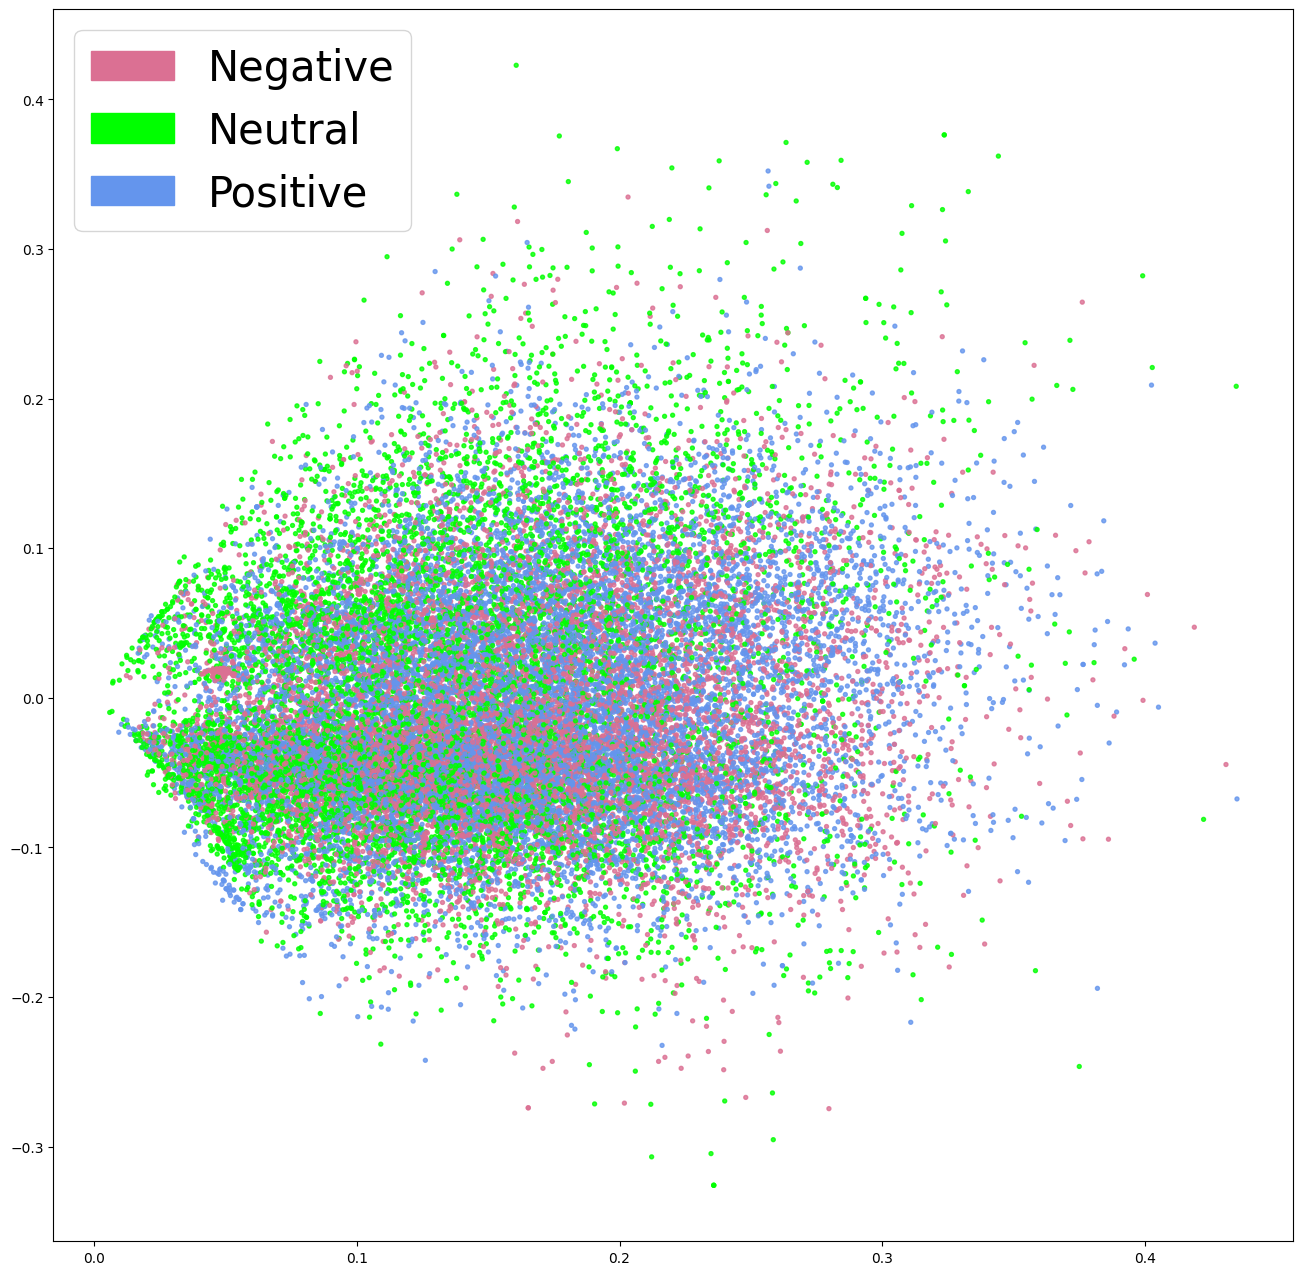

In [49]:
# Dimension Reduction & Plot
from sklearn.decomposition import TruncatedSVD

def plot_LSA(data, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa_scores = lsa.fit_transform(data)  # Use the TF-IDF data for dimensionality reduction
    color_mapper = {label: idx for idx, label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['#DB7093', '#00FF00', '#6495ED']
    if plot:
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=0.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
        pink_patch = mpatches.Patch(color='#DB7093', label='Negative')
        green_patch = mpatches.Patch(color='#00FF00', label='Neutral')
        blue_patch = mpatches.Patch(color='#6495ED', label='Positive')
        plt.legend(handles=[pink_patch, green_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))
plot_LSA(data_tfidf, list_labels)
plt.show()


# Overlap of Sentiments: There is a significant overlap between the different sentiments, especially between neutral and positive sentiments. This could suggest that the features (or words) used to represent the text data might not be sufficiently discriminative to distinctly separate the different classes of sentiments.
# 
# Distribution: The data points are mostly concentrated in a triangular region in the lower left corner of the plot. There are a few outliers, but most of the data is grouped together. 
# 
# Class Separability: Based on the color coding, there is no clear boundary between the sentiment classes. However, there seems to be a slight trend where some sentiments are more concentrated in certain areas, like a higher concentration of positive (blue) points towards the top of the plot.


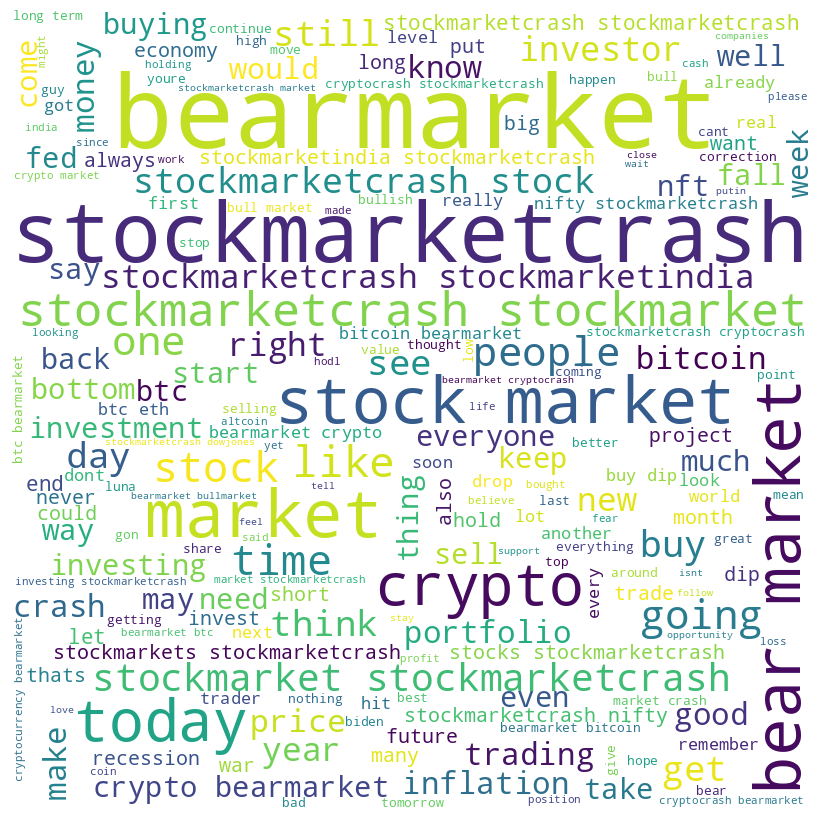

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
text = " ".join(tweet for tweet in SA_data.text_preprocessed)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# A lot of sentiments towards market crash as we can see,people tend to react to something negative more I guess